# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [ ]:
#from get_data import unpack
#unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [3]:
import os
from pathlib import Path
import pandas as pd

def read_images(csv_filename):    
    df = pd.read_csv(csv_filename)
    img_folder = csv_filename.parent.joinpath("images")
    
    images = {int(name.split(".")[0]): plt.imread(img_folder.joinpath(name)) for name in df.filename}
    labels = pd.Series(df.class_id.values, index=df.filename.map(lambda x: int(str(x).split(".")[0]))).to_dict()
    
    return images, labels

def read_videos(csv_filename):    
    df = pd.read_csv(csv_filename)
    img_folder = csv_filename.parent.joinpath("videos")
    
    images = {int(name): [plt.imread(img) for img in img_folder.joinpath(name).glob("*.jpg")] for name in df.filename.apply(str)}
    labels = pd.Series(df.class_id.values, index=df.filename).to_dict()
    
    return images, labels

In [4]:
import os
from pathlib import Path

def load_image_data(dir_name = 'Face_Recognition_data' + os.path.sep + 'image_classification'):
    """Your implementation"""    
    x_train, y_train = read_images(next(Path(os.path.join(dir_name, "train")).glob("*.csv")))
    x_test, y_test = read_images(next(Path(os.path.join(dir_name, "test")).glob("*.csv")))
    
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

In [5]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

In [ ]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [6]:
def load_video_data(dir_name = 'Face_Recognition_data' + os.path.sep + 'video_classification'):
    """Your implementation"""    
    x_train, y_train = read_images(next(Path(os.path.join(dir_name, "train")).glob("*.csv")))
    x_test, y_test = read_videos(next(Path(os.path.join(dir_name, "test")).glob("*.csv")))
    
    return x_train, y_train, x_test, y_test

In [ ]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

In [ ]:
visualize(video_train, train_labels)

In [ ]:
visualize({i:video_test[i][1] for i in video_test.keys()}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [7]:
import facenet
from mtcnn.mtcnn import MTCNN
import pandas as pd
from PIL import Image

def preprocess_imgs(imgs, is_video=False):
    """Your implementation"""
    max_size = 224

    detector = MTCNN()
    results = [detector.detect_faces(img) for img in imgs]
    results = pd.DataFrame([res[0] for res in results])
    results['box'] = results.reset_index().apply(lambda x: [x['index']] + x['box'], axis=1)
    results['faces'] = results['box'].apply(lambda box: imgs[box[0]][max(box[2], 0): max(box[2], 0)+ box[4], max(box[1], 0):max(box[1], 0) + box[3]])
    
    results['ratio'] = results['faces'].apply(lambda x: max_size / min(x.shape[:2]))
    crop_value = lambda size, ratio: (max(int(size * ratio), max_size) - max_size) // 2
    # PIL img has inverted x and y coordinates
    results['crop'] = results.apply(lambda row: (crop_value(row['faces'].shape[1], row['ratio']), crop_value(row['faces'].shape[0], row['ratio'])), axis = 1)
    
    results['img'] = results['faces'].apply(Image.fromarray)
    results['img_rsz'] = results.apply(lambda row: row['img'].resize(( map(lambda x: max(int(row['ratio']*x), max_size), row['img'].size) )), axis = 1)
    pad_value = lambda x: max(x[0]-x[1]*2 - max_size, 0)
    results['pad'] = results.apply(lambda row: list(map(pad_value, zip(row['img_rsz'].size, row['crop']))), axis=1)
    
    crop_coord = lambda row: (row['pad'][0] + row['crop'][0], row['pad'][1] + row['crop'][1], 
                          row['img_rsz'].size[0] - row['crop'][0], row['img_rsz'].size[1] - row['crop'][1])
    results['img_crop'] = results.apply(lambda row: row['img_rsz'].crop(crop_coord(row)), axis=1)
        
    return results['img_crop']

#### Visualization of preprocessing

In [ ]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

In [ ]:
visualize(video_train, train_labels, function = lambda x:preprocess_imgs(x)[0])

In [ ]:
x_train_faces = preprocess_imgs([img for key, img in sorted(x_train.items())])
x_train_faces = x_train_faces.apply(np.asarray)
y_train_faces = y_train

In [ ]:
x_video_train_faces = preprocess_imgs([img for key, img in sorted(video_train.items())])
x_video_train_faces = x_video_train_faces.apply(np.asarray)
y_video_train_faces = train_labels

In [ ]:
x_test_faces = preprocess_imgs([img for key, img in sorted(x_test.items())])
x_test_faces = x_test_faces.apply(np.asarray)
y_test_faces = y_test

In [ ]:
x_video_test_faces = {k: preprocess_imgs(imgs) for k, imgs in sorted(video_test.items())}
y_video_test_faces = test_labels

In [ ]:
plt.imshow(x_video_test_faces[0][4])

In [ ]:
import pickle

data_path = "Face_Recognition_data"
with open(Path(os.path.join(data_path, 'x_train_faces.pickle')), 'wb') as file:
    pickle.dump(x_train_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path(os.path.join(data_path, 'y_train_faces.pickle')), 'wb') as file:
    pickle.dump(y_train_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(Path(os.path.join(data_path, 'x_video_train_faces.pickle')), 'wb') as file:
    pickle.dump(x_video_train_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path(os.path.join(data_path, 'y_video_train_faces.pickle')), 'wb') as file:
    pickle.dump(y_video_train_faces, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(Path(os.path.join(data_path, 'x_test_faces.pickle')), 'wb') as file:
    pickle.dump(x_test_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path(os.path.join(data_path, 'y_test_faces.pickle')), 'wb') as file:
    pickle.dump(y_test_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(Path(os.path.join(data_path, 'x_video_test_faces.pickle')), 'wb') as file:
    pickle.dump(x_video_test_faces, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path(os.path.join(data_path, 'y_video_test_faces.pickle')), 'wb') as file:
    pickle.dump(y_video_test_faces, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
x_train_faces_all = {f'i_{k}': v for k, v in x_train_faces.items()}
x_train_faces_all.update({f'v_{k}': v for k, v in x_video_train_faces.items()})
y_train_faces_all = {f'i_{k}': v for k, v in y_train_faces.items()}
y_train_faces_all.update({f'v_{k}': v for k, v in y_video_train_faces.items()})
print(len(x_train_faces_all), len(y_train_faces_all))

In [ ]:
import pickle

data_path = "Face_Recognition_data"
with open(Path(os.path.join(data_path, 'x_train_faces_all.pickle')), 'wb') as file:
    pickle.dump(x_train_faces_all, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path(os.path.join(data_path, 'y_train_faces_all.pickle')), 'wb') as file:
    pickle.dump(y_train_faces_all, file, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
import pickle

data_path = "Face_Recognition_data"
with open(Path(os.path.join(data_path, 'x_train_faces.pickle')), 'rb') as file:
    x_train_faces = pickle.load(file)
with open(Path(os.path.join(data_path, 'y_train_faces.pickle')), 'rb') as file:
    y_train_faces = pickle.load(file)

with open(Path(os.path.join(data_path, 'x_video_train_faces.pickle')), 'rb') as file:
    x_video_train_faces = pickle.load(file)
with open(Path(os.path.join(data_path, 'y_video_train_faces.pickle')), 'rb') as file:
    y_video_train_faces = pickle.load(file)
    
with open(Path(os.path.join(data_path, 'x_test_faces.pickle')), 'rb') as file:
    x_test_faces = pickle.load(file)
with open(Path(os.path.join(data_path, 'y_test_faces.pickle')), 'rb') as file:
    y_test_faces = pickle.load(file)
    
with open(Path(os.path.join(data_path, 'x_video_test_faces.pickle')), 'rb') as file:
    x_video_test_faces = pickle.load(file)
with open(Path(os.path.join(data_path, 'y_video_test_faces.pickle')), 'rb') as file:
    y_video_test_faces = pickle.load(file)

In [9]:
import pickle

data_path = "Face_Recognition_data"
with open(Path(os.path.join(data_path, 'x_train_faces_all.pickle')), 'rb') as file:
    x_train_faces_all = pickle.load(file)
with open(Path(os.path.join(data_path, 'y_train_faces_all.pickle')), 'rb') as file:
    y_train_faces_all = pickle.load(file)

Halle_Berry


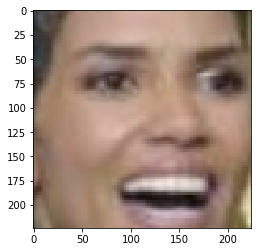

In [10]:
# Combine image and video train
plt.imshow(x_train_faces[250])
print(y_train_faces[250])

Halle_Berry


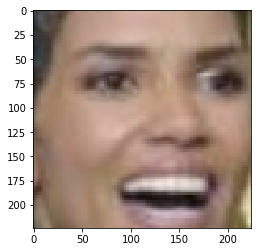

In [11]:
# Combine image and video train
plt.imshow(x_train_faces_all['i_250'])
print(y_train_faces_all['i_250'])

In [ ]:
#x_train_faces_all2 = {**x_train_faces.add_prefix('img_').to_dict(), **x_video_train_faces.add_prefix('vid_').to_dict()}
#y_train_faces_all2 = {**{f'img_{k}': v for k, v in y_train_faces.items()}, **{f'vid_{k}': v for k, v in y_video_train_faces.items()}}
#plt.imshow(x_train_faces_all2['img_250'])
#print(y_train_faces_all2['img_250'])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [32]:
import h5py
from tensorflow.keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       2

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [13]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [14]:
img = cv2.resize(x_train_faces_all['i_0'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [34]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import cv2
from os.path import join

def most_common(lst):
    lst = list(lst)
    return max(set(lst), key=lst.count)

class Classifier():
    def __init__(self, nn_model, n_classes, last_layer_name='fc7'):
        """Your implementation"""
        network_output = nn_model.get_layer(last_layer_name).output
        predictions = Dense(n_classes, activation='softmax', name='prediction')(network_output)
        self.model_faces = Model(inputs=nn_model.input, outputs=predictions)
        print(self.model_faces.summary())
        for layer in nn_model.layers:
            layer.trainable = False


    def fit(self, train_imgs, train_labels, epochs1=40, epochs2=10):
        """Your implementation"""
        # create encoder and decoder for target
        self.target_encoder, self.target_decoder = {}, {}
        for i, k in enumerate(sorted(list(set(list(train_labels.values()))))):
            self.target_encoder[k] = i
            self.target_decoder[i] = k
            
        X_all = []
        y_all = []
        for k in train_imgs.keys():
            X_all += [train_imgs[k]]
            y_all += [self.target_encoder[train_labels[k]]]
        X_all = np.array(X_all, dtype=np.float32)
        y_all = np.array(y_all, dtype=np.uint8)
        X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.8, random_state=34)
        
        # data generator to image augmentation over the procesed images
        datagen = ImageDataGenerator(
                shear_range=0.05,
                zoom_range=0.2,
                rotation_range=10,
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True)
        
        # Select optimizer and compile model
        opt = optimizers.RMSprop(lr=0.001)
        self.model_faces.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        print('Summary of the firts model to train to check the trainable parameters:')
        print(self.model_faces.summary())
        steps = X_train.shape[0] // 32
        history1 = self.model_faces.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = steps,
            epochs = epochs1,
            validation_data = (X_valid, y_valid))
        
        for layer in self.model_faces.layers[:21]:
            layer.trainable = False
        for layer in self.model_faces.layers[21:]:
            layer.trainable = True
            
        opt = optimizers.RMSprop(lr=1E-5)
        self.model_faces.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        print('Summary of the second training')
        self.model_faces.summary()

        history2 = self.model_faces.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = steps,
            epochs = epochs2,
            validation_data = (X_valid, y_valid))
        

    def classify_images(self, test_imgs):
        """Your implementation"""
        return {k: self.target_decoder[np.argmax(self.model_faces.predict(np.array([face]))[0])] 
               for k, face in test_imgs.items()}

    def classify_videos(self, test_video):
        """Your implementation"""
        out = {}
        for k, face_list in test_video.items():
            y = [self.target_decoder[p] for p in np.argmax(self.model_faces.predict(np.array(face_list)), axis=1)]
            out[k] = most_common(y)
        return out

In [35]:
%%time

n_classes = len(set(y_train_faces_all.values()))
print('n_classes: ', n_classes)

classifier = Classifier(model, n_classes)

n_classes:  179
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     1475

In [ ]:
classifier.fit(x_train_faces_all, y_train_faces_all, epochs1=40, epochs2=10)

Summary of the firts model to train to check the trainable parameters:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
________________________________________________________

In [ ]:
import tensorflow as tf
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# My GPU doesn't have enough memory, so checking it's running on CPU
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

In [ ]:
len(set(y_train_faces_all.values()))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import cv2
from os.path import join

n_classes = len(set(y_train_faces_all.values()))
last_layer_name='fc7'
nn_model = model
network_output = nn_model.get_layer(last_layer_name).output
predictions = Dense(n_classes, activation='softmax', name='prediction')(network_output)
model_faces = Model(inputs=nn_model.input, outputs=predictions)
for layer in nn_model.layers:
    layer.trainable = False

target_encoder, target_decoder = {}, {}
for i, k in enumerate(sorted(list(set(list(y_train_faces_all.values()))))):
    target_encoder[k] = i
    target_decoder[i] = k
X_all = []
y_all = []
for k in x_train_all.keys():
    X_all += [x_train_all[k]]
    y_all += [target_encoder[y_train_all[k]]]
X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.uint8)
    
#train_imgs = np.array([face for face in sorted(x_train.items())])
#train_labels = np.array(list(sorted(y_train.keys())))
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.8, random_state=42)

datagen = ImageDataGenerator(
                shear_range=0.05,
                zoom_range=0.2,
                rotation_range=10,
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True)

opt = optimizers.RMSprop(lr=0.001)
model_faces.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print('Summary of the first model to train to check the trainable parameters:')
print(model_faces.summary())

history1 = model_faces.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = X_train.shape[0] // 32,
            epochs = 40,
            validation_data = (X_valid, y_valid))

In [ ]:
from tensorflow.keras.models import model_from_json
# serialize model to JSON
with open("model_faces.json", "w") as json_file:
    json_file.write(model_faces.to_json())
# serialize weights to HDF5
model_faces.save_weights("model.h5")

In [ ]:
import h5py
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

loaded_model = None
with open('model_faces.json', 'r') as json_file:
    loaded_model = model_from_json(json_file.read())
loaded_model.load_weights("model.h5")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

for layer in loaded_model.layers[:21]:
    layer.trainable = False
for layer in loaded_model.layers[21:]:
    layer.trainable = True
            
opt = optimizers.RMSprop(lr=1E-5)
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print('Summary of the second training')
loaded_model.summary()

datagen = ImageDataGenerator(
            shear_range=0.05,
            zoom_range=0.2,
            rotation_range=10,
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True)

target_encoder, target_decoder = {}, {}
for i, k in enumerate(sorted(list(set(list(y_train_faces_all.values()))))):
    target_encoder[k] = i
    target_decoder[i] = k
X_all = []
y_all = []
for k in x_train_faces_all.keys():
    X_all += [x_train_faces_all[k]]
    y_all += [target_encoder[y_train_faces_all[k]]]
X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.uint8)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.8, random_state=42)

history2 = loaded_model.fit_generator(datagen.flow(X_train, y_train),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 10,
    validation_data = (X_valid, y_valid))

In [ ]:
loaded_model.save("last_model.h5")

In [ ]:
loaded_model = load_model("last_model.h5")

n_classes = len(set(y_train_faces_all.values()))
print('n_classes: ', n_classes)
classifier = Classifier(loaded_model, n_classes)

classifier.target_encoder, classifier.target_decoder = {}, {}
for i, k in enumerate(sorted(list(set(list(y_train_faces.values()))))):
    classifier.target_encoder[k] = i
    classifier.target_decoder[i] = k

In [ ]:
y_train_faces[113]

In [24]:
y_out = classifier.classify_images(x_test_faces)

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [ ]:
def classify_images(test_imgs):
        """Your implementation"""
        return {k: target_decoder[np.argmax(loaded_model.predict(np.array([face]))[0])] 
               for k, face in test_imgs.items()}

def classify_videos(test_video):
    """Your implementation"""
    out = {}
    for k, face_list in test_video.items():
        y = [target_decoder[p] for p in np.argmax(loaded_model.predict(np.array(face_list)), axis=1)]
        out[k] = most_common(y)
    return out

In [ ]:
y_out = classify_images(x_test_faces)

Winona_Ryder
(258, 'Luiz_Inacio_Lula_da_Silva')


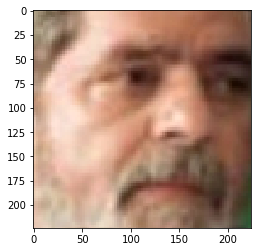

In [25]:
print(y_out[8])
plt.imshow(x_test_faces[8])
print(list(sorted(y_test_faces.items()))[8])

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [26]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in output.items():
        if gt[k][1] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [27]:
print(check_test(y_out, list(sorted(y_test_faces.items()))))

Classification accuracy is 0.0149


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [ ]:
loaded_model.predict(np.array(x_video_test_faces[0][0]))

In [28]:
y_video_out = classify_videos(x_video_test_faces)

NameError: name 'classify_videos' is not defined

In [ ]:
np.array(x_video_test_faces[0])

In [30]:
#video_classifier = Classifier(model)
#video_classifier.fit(video_train, train_labels)
y_video_out = classifier.classify_videos(x_video_test_faces)

ValueError: Error when checking input: expected conv1_1_input to have 4 dimensions, but got array with shape (125, 1)

In [ ]:
print check_test(y_video_out, test_labels)